# Assignment 1.1: NARMA10 task with ESN
This task consists of predicting the output of a 10th order non-linear autoregressive moving average (NARMA) system.
Given the input value x(t), the task is to predict the corresponding value of y(t).
* Import the dataset from the .csv file “NARMA10.csv” (available on the Moodle platform), where the first row represents the input, and the second row represents the target output. Different columns represent different time-steps.
* Split the data into training (the first 5000 time steps), and test set (remaining time steps). Note that for model selection you will use the data in the training set, with a further split in training (first 4000 samples) and validation (last 1000 samples).
* For the sake of problem understanding, you can try to first visualize the time-series data (using the matplotlib library in Python or the plot command in Matlab)

1) Implement from the scratch the code required to initialize, run, train and evaluate an Echo State Network (in NumPy or Matlab). Your implementation should take into consideration relevant hyper-parametrization of the neural network (e.g., number of reservoir neurons, spectral radius, etc.)

2) Perform a model selection (e.g., by grid search or random search) on the values of the hyperparameters identified in the previous point. Select on the validation set the best hyper-parametrization, as the one with the smallest Mean Squared Error (MSE).

3) Train the ESN model with the selected hyper-parametrization on the whole training set, and evaluate its MSE on the training set and on the test set.


NOTE: For each hyper-parameterization that you consider, the performance (on training, validation and test sets) should be averaged over a number of reservoir guesses, i.e., different random instances of ESNs with the same values of the hyperparameters (and potentially different random weights)

# Bonus-track Assignment 1.2: Mackey-Glass 17 task with ESN

Solve the same assignment as in the previous exercise, this time referring to the Mackey-Glass (MG) 17 task (see details on this task in the previous lab assignment file).

## Libraries

In [4]:
import sys, copy, json, pickle
import pandas as pd

from tqdm import tqdm
from numpy import vstack
from statistics import mean
from itertools import product

# To work with Google colab
#!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/Utils/utils.py
#!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/LAB3_2/Assignment1/NumpyEchoStateNetworks.py
#!mkdir caches

from Utils.utils import make_sequence, show_result
from LAB3_2.Assignment1.NumpyEchoStateNetworks import ESN_seq2seq

## Retrieve the datasets

In [5]:
# To work with Google colab
#!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/Sources/NARMA10.csv
#!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/Sources/MG17.csv
source1 = pd.read_csv("./../../Sources/NARMA10.csv", header=None).T.to_numpy()
source2 = pd.read_csv("./../../Sources/MG17.csv", header=None).T.to_numpy()

## Trainer and Grid-search function

In [6]:
class GridSearch:

    def __init__(self, parameters_grid:dict, tr:tuple, dev:tuple):

        all_configs = [dict(zip(parameters_grid.keys(), configs)) for configs in product(*parameters_grid.values())]

        print("Number of configurations to try: ",len(all_configs))

        """
        Returns the performance in each configuration:

            rank = a list of results for each configuration
            best = best model used to final retrain
            loss = training loss history of the best model
        """
        rank, best = self.run(tr, dev, all_configs)

        # we sort by validation loss
        rank = sorted(rank, key=lambda conf: conf[2])

        print("\nThe best solution in ", rank[0])
        self.best_config = rank[0][0]
        self.best_model = best # the best model discovered

    @staticmethod
    def run(tr:tuple, dev:tuple, configs:list):
        """
        In the grid search, we explore all configurations provided and try to find the best
        hyperparameter configuration using the training set to train the model and the validation
        set to compare the performance among all models instantiated by configurations.
        """

        rank = [] # keep in track the configuration and the corresponding performance

        # we save the best trained model and the training loss history during the epochs
        best, loss = None, None
        best_dev_loss = sys.maxsize

        for config in tqdm(configs): # try each configuration


            tr_loss_, vl_loss, trainer = multiple_train(tr, dev, config)

            rank.append((config, round(tr_loss_, 6), round(vl_loss, 6)))

            # we keep the best model
            if best_dev_loss > vl_loss:
                best_dev_loss = vl_loss
                best = copy.deepcopy(trainer)

        return rank, best

def multiple_train(tr:tuple, dev:tuple, config:dict)-> tuple[float, float, ESN_seq2seq]:

    tr_losses, vl_losses, trainer = [],[], None

    for i in range(5):
        trainer = ESN_seq2seq(1, hidden_dim=config["units"],
                              omega=config["omega"],
                              spectral_radius=config["radius"],
                              tikhonov=config["tikhonov"])

        tr_loss_, last_h_ = trainer.fit(*tr, transient=100)
        vl_loss, _ = trainer.validate(*dev, h0=last_h_)

        tr_losses.append(tr_loss_)
        vl_losses.append(vl_loss)

    return mean(tr_losses), mean(vl_losses), trainer

## NARMA10

### Hold-out

In [7]:
tr_dataset = make_sequence(source1[:4000], 1, "NARMA10", to_numpy=True)
dev_dataset = make_sequence(source1[4000:5000], 1, "NARMA10", to_numpy=True)
ts_dataset = make_sequence(source1[5000:], 1, "NARMA10", to_numpy=True)

### Grid search

In [8]:
json_dictionary = {"NARMA": {}, "MG17": {}}

In [9]:
ranges_to_explore = {
    "units" : [20, 50, 100, 150],
    "omega" : [0.2, 0.5, 0.7],
    "radius" : [0.7, 0.8, 0.9],
    "tikhonov" : [1e-3, 1e-4, 1e-5]
}

gs = GridSearch(ranges_to_explore, tr_dataset, dev_dataset)
best_config = gs.best_config
best_model = gs.best_model

json_dictionary["NARMA"]["best_config"] = best_config

Number of configurations to try:  108


100%|██████████| 108/108 [00:33<00:00,  3.23it/s]


The best solution in  ({'units': 150, 'omega': 0.5, 'radius': 0.9, 'tikhonov': 1e-05}, 0.000165, 0.000223)


### Train, Validation and Test errors in the best configuration

In [10]:
tr_loss, last_h = best_model.validate(*tr_dataset)
print("Train Error", round(tr_loss, 6))

dev_loss, last_h = best_model.validate(*dev_dataset,h0=last_h)
print("Validation Error", round(dev_loss, 6))

ts_loss, _ = best_model.validate(*ts_dataset, h0=last_h)
print("Test Error", round(ts_loss, 6))

json_dictionary["NARMA"]["best_config"] = best_config
json_dictionary["NARMA"]["Model_evaluation"] = (
    round(tr_loss.item(),6),
    round(dev_loss.item(),6),
    round(ts_loss.item(),6))

Train Error 0.194739
Validation Error 0.000199
Test Error 0.000187


### Final retrain with Training and Validation set (with the best configuration)

In [11]:
final_trainer = ESN_seq2seq(1, hidden_dim=best_config["units"],
                              omega=best_config["omega"],
                              spectral_radius=best_config["radius"],
                              tikhonov=best_config["tikhonov"])


final_tr = tuple(vstack((x, y)) for x, y in zip(tr_dataset, dev_dataset))

tr_loss, last_h = final_trainer.fit(*final_tr, transient=100)
print("Train Error", round(tr_loss, 6))

ts_loss, _ = final_trainer.validate(*ts_dataset, h0=last_h)
print("Test Error", round(ts_loss, 6))

with open(f"caches/narma_model.pickle","wb") as file:
    pickle.dump(final_trainer, file)

json_dictionary["NARMA"]["Final_retrain"] = (
    round(tr_loss.item(),6),
    round(ts_loss.item(),6))

Train Error 0.000144
Test Error 0.000165


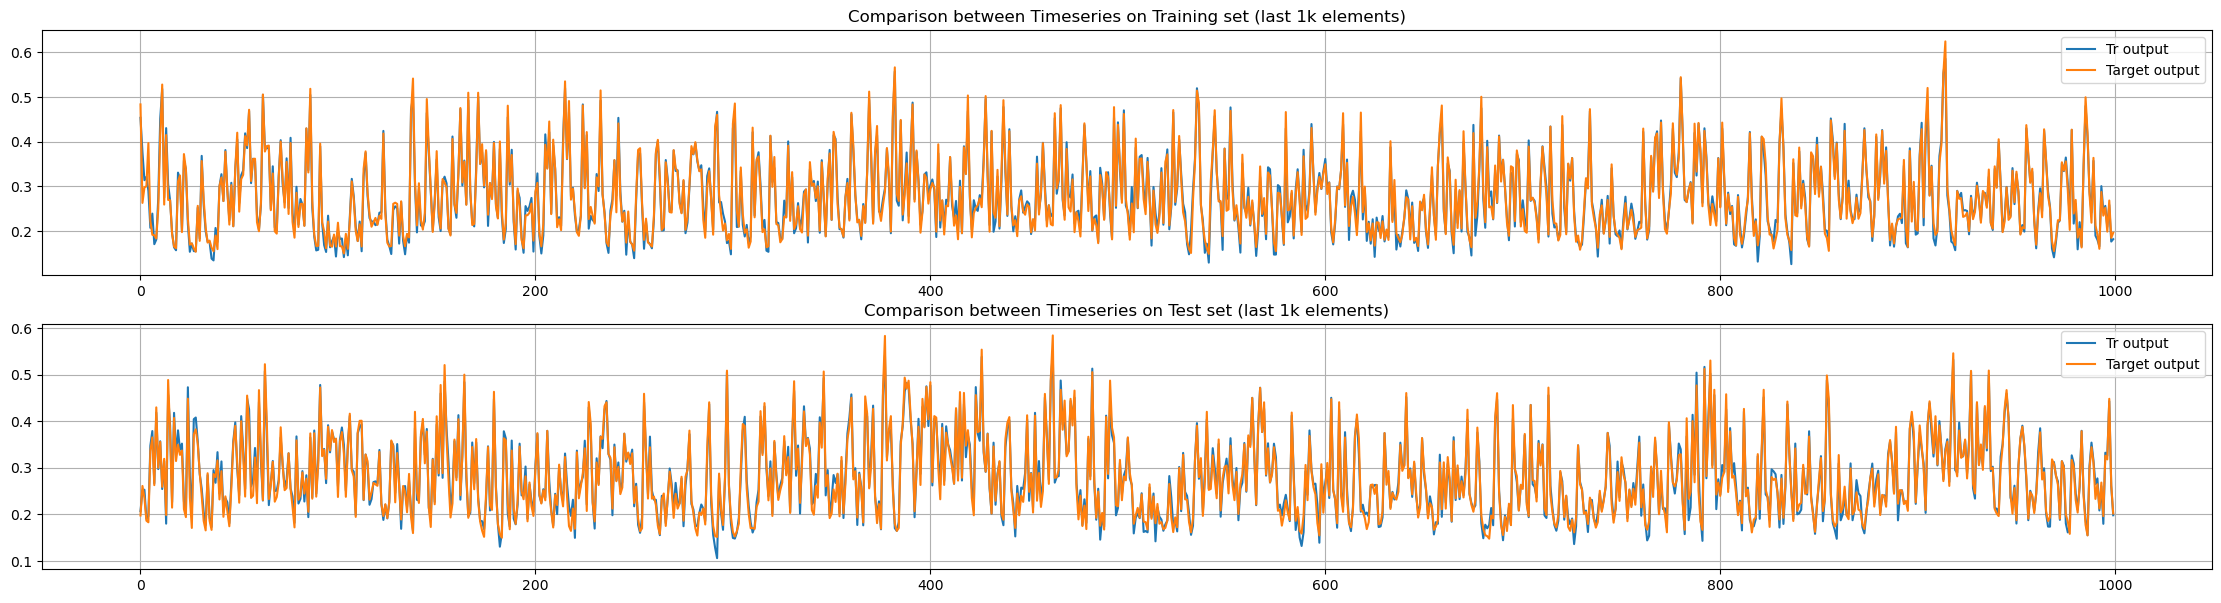

In [12]:
_, _, tr_pred = best_model.predict(*final_tr)
_, _, ts_pred = best_model.predict(*ts_dataset)
show_result(tr_pred, final_tr[1], ts_pred, ts_dataset[1])

In [13]:
json_dictionary["NARMA"]["tr_pred"] = tr_pred.tolist()
json_dictionary["NARMA"]["tr_y"] = final_tr[1].tolist()
json_dictionary["NARMA"]["ts_pred"] = ts_pred.tolist()
json_dictionary["NARMA"]["ts_y"] = ts_dataset[1].tolist()

## Mackey-Glass 17

### Hold-out

In [14]:
tr_dataset = make_sequence(source2[:4000], 1, "MG17", to_numpy=True)
dev_dataset = make_sequence(source2[4000:5000], 1, "MG17", to_numpy=True)
ts_dataset = make_sequence(source2[5000:], 1, "MG17", to_numpy=True)

### Grid search

In [15]:
gs = GridSearch(ranges_to_explore, tr_dataset, dev_dataset)
best_config = gs.best_config
best_model = gs.best_model

json_dictionary["MG17"]["best_config"] = best_config

Number of configurations to try:  108


100%|██████████| 108/108 [00:34<00:00,  3.16it/s]


The best solution in  ({'units': 50, 'omega': 0.2, 'radius': 0.9, 'tikhonov': 1e-05}, 0.0, 1e-06)


### Train, Validation and Test errors in the best configuration

In [16]:
tr_loss, last_h = best_model.validate(*tr_dataset)
print("Train Error", round(tr_loss, 6))

dev_loss, last_h = best_model.validate(*dev_dataset, h0=last_h)
print("Validation Error", round(dev_loss, 6))

ts_loss, _ = best_model.validate(*ts_dataset, h0=last_h)
print("Test Error", round(ts_loss, 6))

json_dictionary["MG17"]["best_config"] = best_config
json_dictionary["MG17"]["Model_evaluation"] = (
    round(tr_loss.item(), 6),
    round(dev_loss.item(), 6),
    round(ts_loss.item(), 6))

Train Error 0.000251
Validation Error 1e-06
Test Error 2e-06


### Final retrain with Training and Validation set (with the best configuration)

In [17]:
final_trainer = ESN_seq2seq(1, hidden_dim=best_config["units"],
                            omega=best_config["omega"],
                            spectral_radius=best_config["radius"],
                            tikhonov=best_config["tikhonov"])

final_tr = tuple(vstack((x, y)) for x, y in zip(tr_dataset, dev_dataset))

tr_loss, last_h = final_trainer.fit(*final_tr, transient=100)
print("Train Error", round(tr_loss, 6))

ts_loss, _ = final_trainer.validate(*ts_dataset, h0=last_h)
print("Test Error", round(ts_loss, 6))

with open(f"caches/mg17_model.pickle","wb") as file:
    pickle.dump(final_trainer, file)

json_dictionary["MG17"]["Final_retrain"] = (
    round(tr_loss.item(), 6),
    round(ts_loss.item(), 6))

Train Error 1e-06
Test Error 2e-06


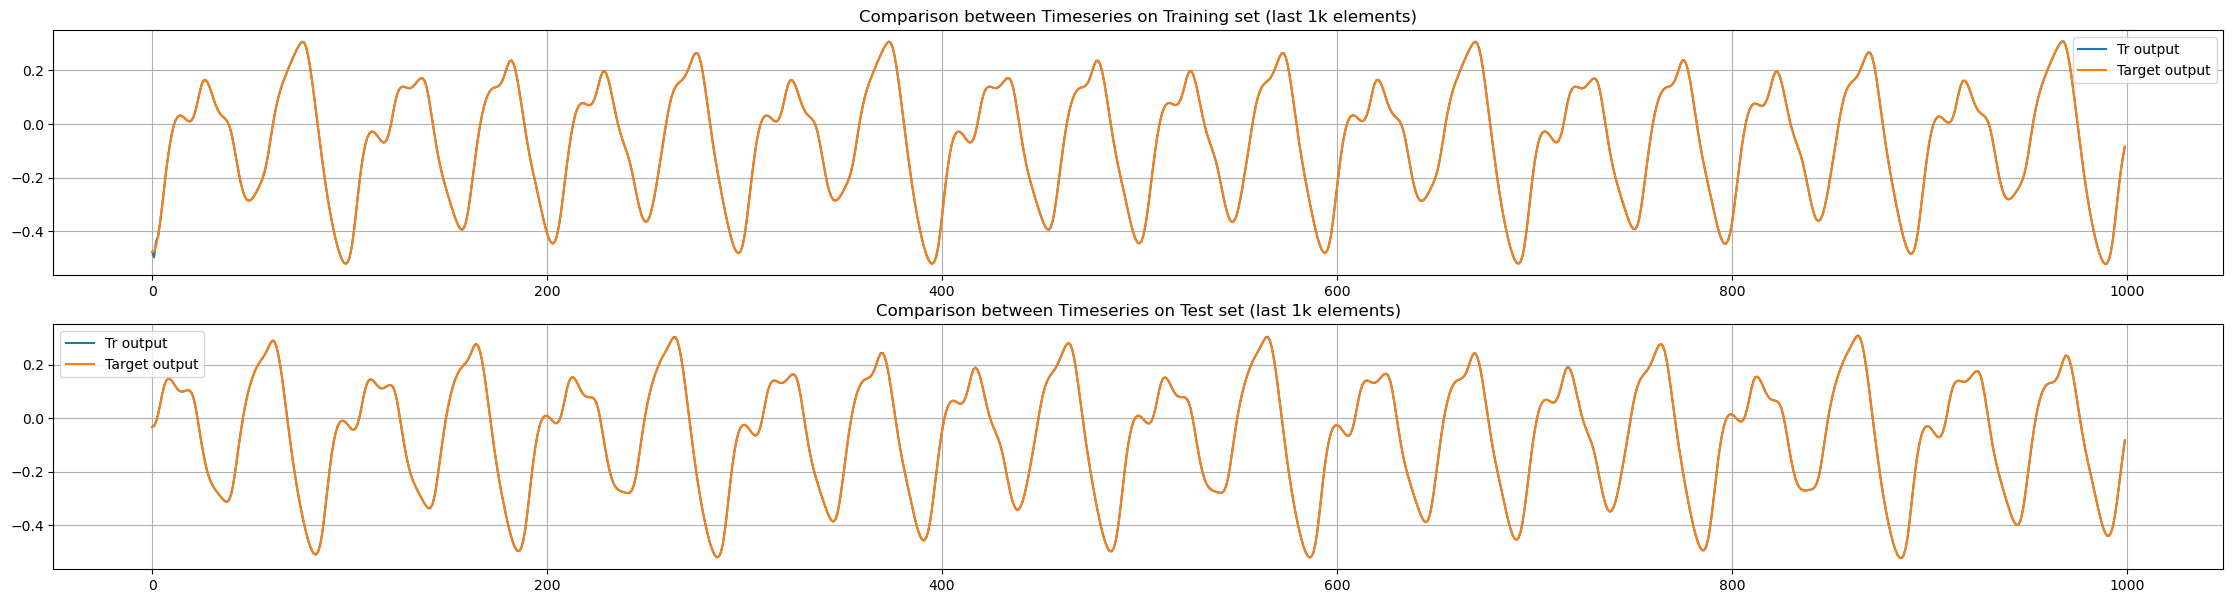

In [18]:
_, _, tr_pred = best_model.predict(*final_tr)
_, _, ts_pred = best_model.predict(*ts_dataset)
show_result(tr_pred, final_tr[1], ts_pred, ts_dataset[1])

In [19]:
json_dictionary["MG17"]["tr_pred"] = tr_pred.tolist()
json_dictionary["MG17"]["tr_y"] = final_tr[1].tolist()
json_dictionary["MG17"]["ts_pred"] = ts_pred.tolist()
json_dictionary["MG17"]["ts_y"] = ts_dataset[1].tolist()

In [20]:
with open("caches/metric_esn.json", "w") as outfile:
    outfile.write(json.dumps(json_dictionary))